# Momentum with Rate of Change (ROC) strategy research
По мотивам лекций 1-3 курса `Advanced Algorithmic Futures Trading with Limex`

## Предисловие
Автор долго пытался понять и самостоятельно написать функции из ноутбука `a1` ко второй лекции, но что-то пошло не так и он решёл пойти по другому пути разработки стратегии с помощью библеотеки `Zipline` от `Quantopian`. По совету Владислава Самсонова и от `Zipline` автор тоже отказался и пришёл к использованию `Backtrader`. 

Выбор стратегии для исследования обусловлен простотой реализации, так как целью этого исселедования является не разработка мощной торговой тратегии, а демонстрация работы связки `backtrader-pyfolio` и умения автора находить оптимальные параметры для стратегии

Данное исследование можно разделить на 2 части:
1. Краткое введение в библеотеку `Backtrader` и анализ результатов работы стратегии с помощью упомянутой в курсе библиотеки `pyfolio`
2. Оптимизация параметров стратегии

## Краткое введерние в теорию стратегии


### Идея стратегии
Стратегия "Momentum with Rate of Change (ROC)" основана на идее **моментума**, который утверждает, что активы, демонстрирующие рост цен, имеют тенденцию продолжать расти, а активы, которые падают, имеют тенденцию продолжать падение.

Индикатор **Rate of Change (ROC)** измеряет скорость изменения цены актива за заданный период. Он позволяет выявлять, насколько быстро цена изменяется, что помогает определять направление и силу текущего тренда.



### Формула индикатора ROC

Индикатор ROC вычисляется как процентное изменение цены за определённый период N:
$
ROC = \frac{{P_t - P_{t-N}}}{{P_{t-N}}} \times 100
$
где:
- $P_t$: текущая цена.
- $P_{t-N}$: цена $N$-периодов назад.

### Интерпретация ROC

1. **Положительное значение ROC (> 0):**
   - Цена актива растёт по сравнению с ценой N-периодов назад.
   - Указывает на восходящий моментум.
   - Сигнал к **покупке**.

2. **Отрицательное значение ROC (< 0):**
   - Цена актива снижается по сравнению с ценой N-периодов назад.
   - Указывает на нисходящий моментум.
   - Сигнал к **продаже**.

3. **Нулевое значение ROC (ROC = 0):**
   - Цена актива осталась неизменной за период \( N \).

### Торговая логика

#### Условия для покупки:
- Если \( ROC > 0 \): цена демонстрирует положительный моментум.
- Это сигнал к открытию длинной позиции (long).

#### Условия для продажи:
- Если \( ROC < 0 \): цена демонстрирует отрицательный моментум.
- Это сигнал к закрытию длинной позиции или открытию короткой позиции (short).

## Часть 1

Для начала установим необходимые зависимости

In [97]:
!pip install pyfolio-reloaded
!pip install backtrader
!pip install yfinance

Далее определим класс стратегии

In [99]:
import backtrader as bt
import datetime

class ROCMomentumStrategy(bt.Strategy):

    # Метод для получения количества лотов для покупки или продажи в каждой сделке,
    # для простоты пока будем рисковать фиксированным процентом
    def getsizing(self, cash):
        # Рассчитываем риск
        risk_amount = cash * 0.02
        stop_loss = 200
        size = int(risk_amount / stop_loss)
        return size
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=20)

    def next(self):
        cash = self.broker.get_cash()
        size = self.getsizing(cash)

        if not self.position:
            if self.roc[0] > 0:
                self.log(f'BUY CREATE, {self.data.close[0]:.2f}')
                self.buy(size=size)
        else:
            if self.roc[0] < 0:
                self.log(f'SELL CREATE, {self.data.close[0]:.2f}')
                self.sell(size=self.position.size)

Далее необходимо загрузить данные для исследование

In [101]:
# Код для скачивания данных, после скачивнаия в файле надо удалить первые строчки
# import yfinance as yf
# # Указываем диапазон дат
# start_date = "2019-01-01"
# end_date = "2025-01-01"
# # Загружаем данные Apple (тикер AAPL)
# data = yf.download("AAPL", start=start_date, end=end_date, interval="1d")
# data.to_csv("AAPL_2019_to_2025_daily.csv")

data = bt.feeds.GenericCSVData(
    dataname='/Users/timurgattarov/algotrading/Onboarding Research/AAPL_2019_to_2025_daily.csv',
    dtformat='%Y-%m-%d',      # Формат даты
    timeframe=bt.TimeFrame.Days,  # Таймфрейм данных (дневной)
    fromdate=datetime.datetime(2020, 1, 1),
    # Указываем индексы столбцов
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)

In [103]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(ROCMomentumStrategy)
# Выставляем стартовый капитал
cerebro.broker.set_cash(1000000.0)
# Выставляем коммисию
cerebro.broker.setcommission(commission=0.001)
# Понадобится нам позже 
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()

2020-01-31, BUY CREATE, 75.02
2020-02-21, SELL CREATE, 76.05
2020-04-09, BUY CREATE, 65.11
2020-04-13, SELL CREATE, 66.38
2020-04-14, BUY CREATE, 69.74
2020-09-11, SELL CREATE, 109.33
2020-09-14, BUY CREATE, 112.61
2020-09-16, SELL CREATE, 109.46
2020-10-06, BUY CREATE, 110.46
2020-10-07, SELL CREATE, 112.34
2020-10-08, BUY CREATE, 112.23
2020-10-28, SELL CREATE, 108.55
2020-11-05, BUY CREATE, 116.19
2020-11-09, SELL CREATE, 113.74
2020-11-13, BUY CREATE, 116.62
2020-11-23, SELL CREATE, 111.33
2020-11-25, BUY CREATE, 113.46
2021-01-15, SELL CREATE, 124.32
2021-01-20, BUY CREATE, 129.11
2021-01-29, SELL CREATE, 129.04
2021-02-01, BUY CREATE, 131.17
2021-02-18, SELL CREATE, 127.03
2021-03-31, BUY CREATE, 119.62
2021-05-06, SELL CREATE, 127.06
2021-06-09, BUY CREATE, 124.71
2021-08-11, SELL CREATE, 143.30
2021-08-12, BUY CREATE, 146.28
2021-08-20, SELL CREATE, 145.59
2021-08-23, BUY CREATE, 147.08
2021-09-14, SELL CREATE, 145.52
2021-09-16, BUY CREATE, 146.18
2021-09-17, SELL CREATE, 143.

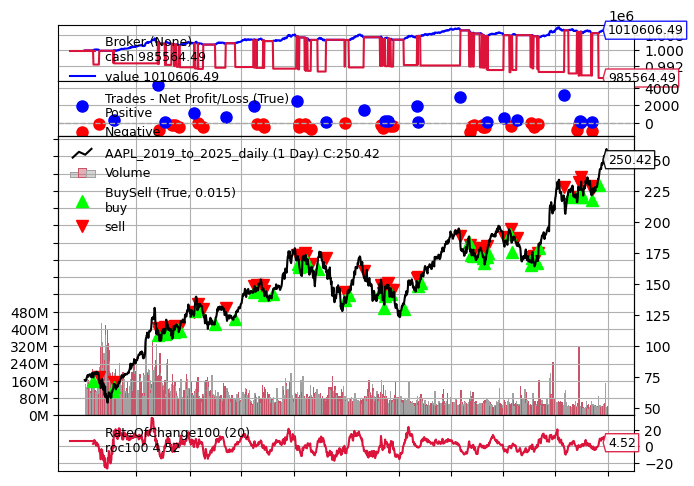

[[<Figure size 640x480 with 5 Axes>]]

In [105]:
''' Построим стандартный график для нашей стратегии (в JupiterNotebook интерактивный графики matplotlib отображаются
не очень хорошо, поэтому стратегии с помощью Backtrader  писать лучще как обычную программу на питоне)'''
%matplotlib inline
cerebro.plot(iplot=False, figsize=(32, 20))

Посмотрим на результаты работы стратегии

In [107]:
print(f"Капитал в конце стратегии : {cerebro.broker.getvalue()}")

Капитал в конце стратегии : 1010606.4890924579


Теперь обработаем нашу стратегию с помощью `pyfolio`

Start date,2020-01-02
End date,2024-12-31
Total months,59
,Backtest
Annual return,0.212%
Cumulative returns,1.061%
Annual volatility,0.304%
Sharpe ratio,0.70
Calmar ratio,0.45
Stability,0.83
Max drawdown,-0.475%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.48,2023-07-31,2024-05-06,2024-07-10,248
1,0.37,2020-09-01,2020-11-27,2021-11-23,321
2,0.33,2022-01-03,2022-02-23,2023-03-31,325
3,0.31,2024-07-16,2024-11-04,NaT,NaN
4,0.09,2021-12-10,2021-12-20,2021-12-27,12


Stress Events,mean,min,max
Covid,0.00%,-0.10%,0.14%


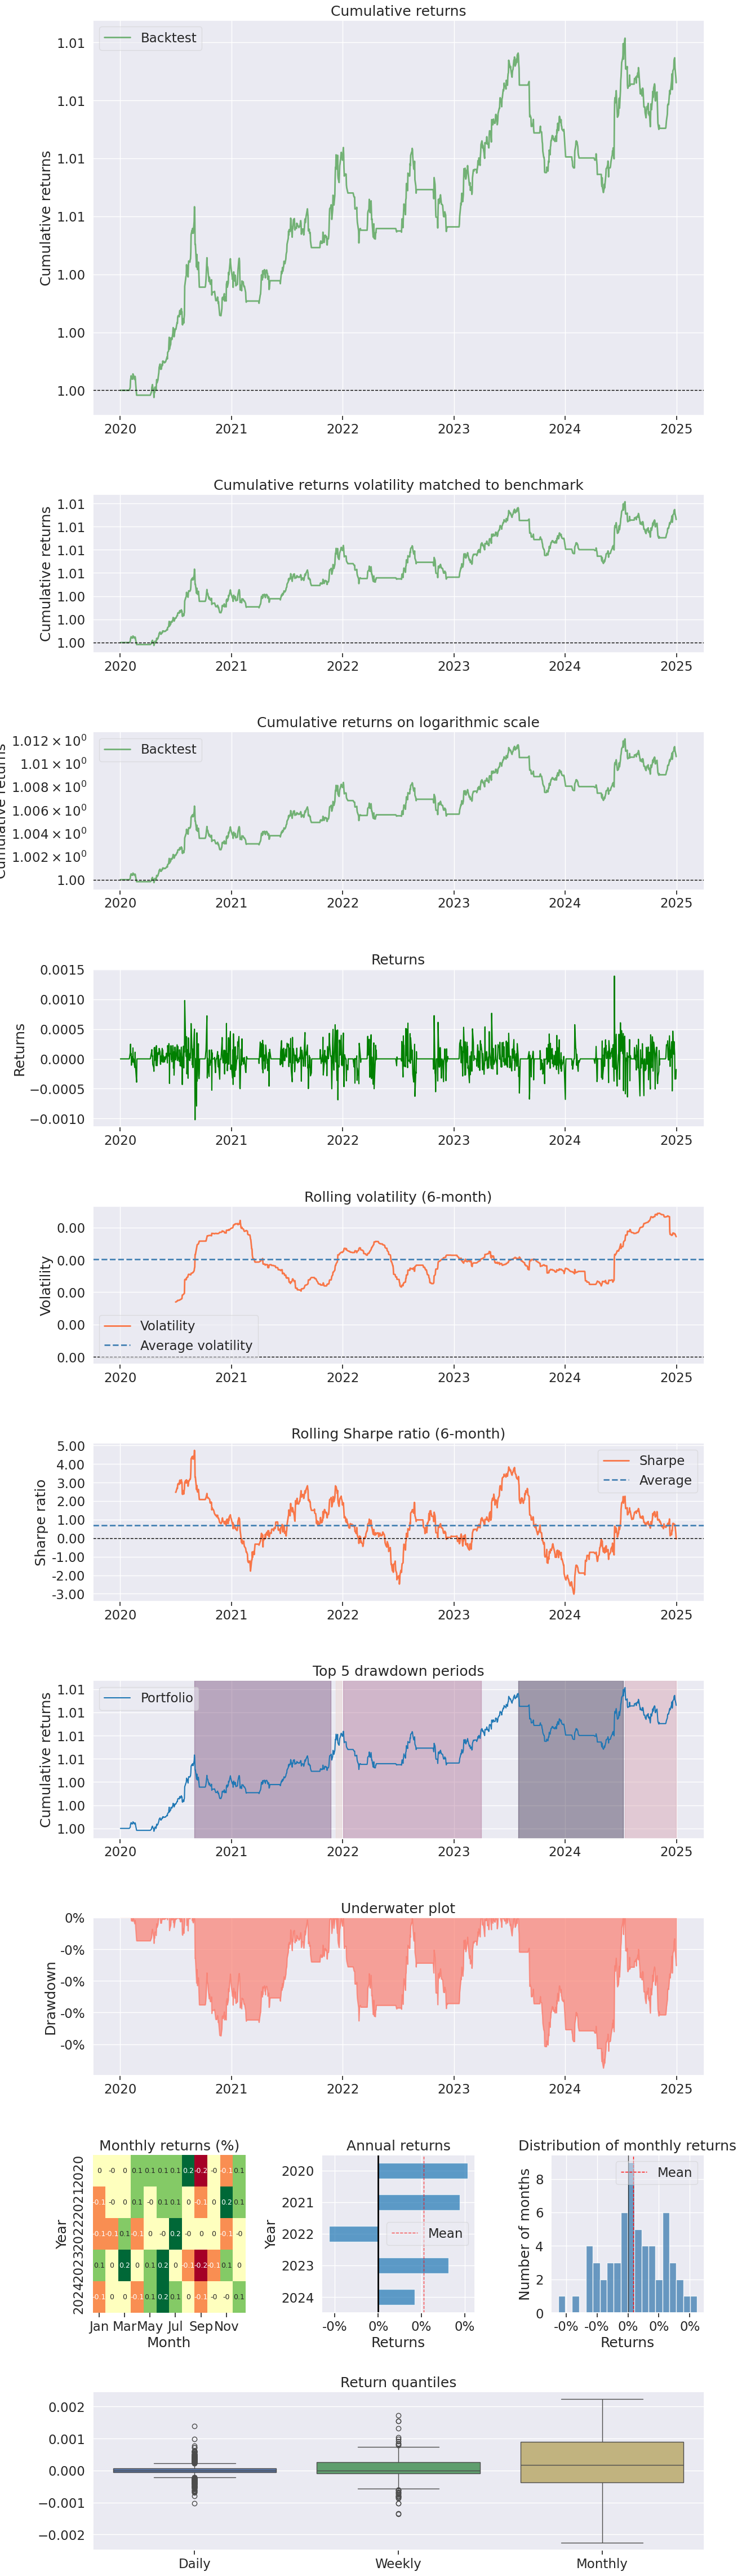

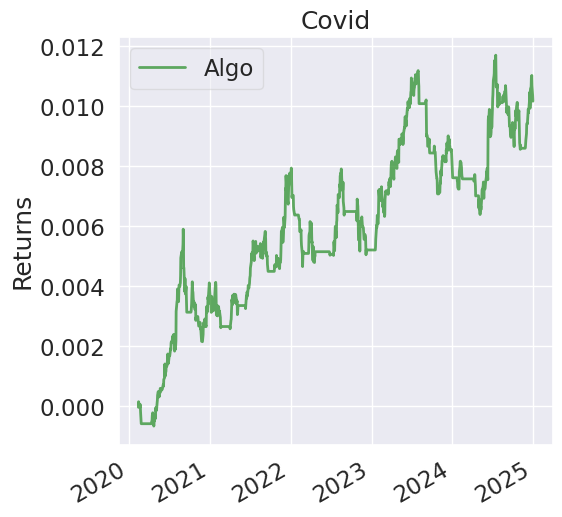

In [109]:
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt


pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
returns = pd.Series(returns, index=pd.to_datetime(returns.index))

pf.create_full_tear_sheet(
    returns=returns,
    benchmark_rets=None,
)
plt.show() 

In [111]:
perf_stats = pf.timeseries.perf_stats(returns)
annual_return = perf_stats['Annual return']
cumulative_return = perf_stats['Cumulative returns']
sharpe_ratio = perf_stats['Sharpe ratio']

print(f"Annual Return: {annual_return:.2%}")
print(f"Сumulative Return: {cumulative_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Annual Return: 0.21%
Сumulative Return: 1.06%
Sharpe Ratio: 0.70


Сделаем некоторые выводы: значения годового и итогового дохода кажутся смешными - что на это влияет? 
1. Stop-loss и процент от кэша, которым мы готовы рисковать
2. Период в `RateOfChange100` - вот зависимость от него мы и попробуем происследовать

Коэффициент Шарпа тоже оставляет желать лучшего, постараемся максимально близко подойти к значению 1.0

## Часть 2

Немного перепишем наш код, так чтобы можно было запускать его при разных параметрах period и снимать зависимость `Sharp Ratio` от него

In [153]:
import backtrader as bt
import datetime
import matplotlib.pyplot as plt

class ROCMomentumStrategy(bt.Strategy):
    params = (
        ('roc_period', 20),
        ('risk_percent', 0.02),
        ('stop_loss', 200),
    )

    def getsizing(self, cash):
        risk_amount = cash * self.params.risk_percent
        size = int(risk_amount / self.params.stop_loss)
        return size
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=self.params.roc_period)

    def next(self):
        cash = self.broker.get_cash()
        size = self.getsizing(cash)

        if not self.position:
            if self.roc[0] > 0:
                # self.log(f'BUY CREATE, {self.data.close[0]:.2f}')
                self.buy(size=size)
        else:
            if self.roc[0] < 0:
                # self.log(f'SELL CREATE, {self.data.close[0]:.2f}')
                self.sell(size=self.position.size)

In [155]:
def run_strategy_with_pyfolio(periods):
    all_returns = []
    roc_periods = []
    
    for period in periods:
        cerebro = bt.Cerebro()
        data = bt.feeds.GenericCSVData(
            dataname='/Users/timurgattarov/algotrading/Onboarding Research/AAPL_2019_to_2025_daily.csv',
            dtformat='%Y-%m-%d',
            timeframe=bt.TimeFrame.Days,
            fromdate=datetime.datetime(2020, 1, 1),
            close=1,
            high=2,
            low=3,
            open=4,
            volume=5,
            openinterest=-1
        )
        cerebro.adddata(data)
        cerebro.addstrategy(ROCMomentumStrategy, roc_period=period)
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
        cerebro.broker.set_cash(1000000.0)
        results = cerebro.run()
        
        pyfolio_analyzer = results[0].analyzers.pyfolio
        returns, _, _, _ = pyfolio_analyzer.get_pf_items()
        returns = pd.Series(returns, index=pd.to_datetime(returns.index))
        
        roc_periods.append(period)
        all_returns.append(returns)
    
    return roc_periods, all_returns

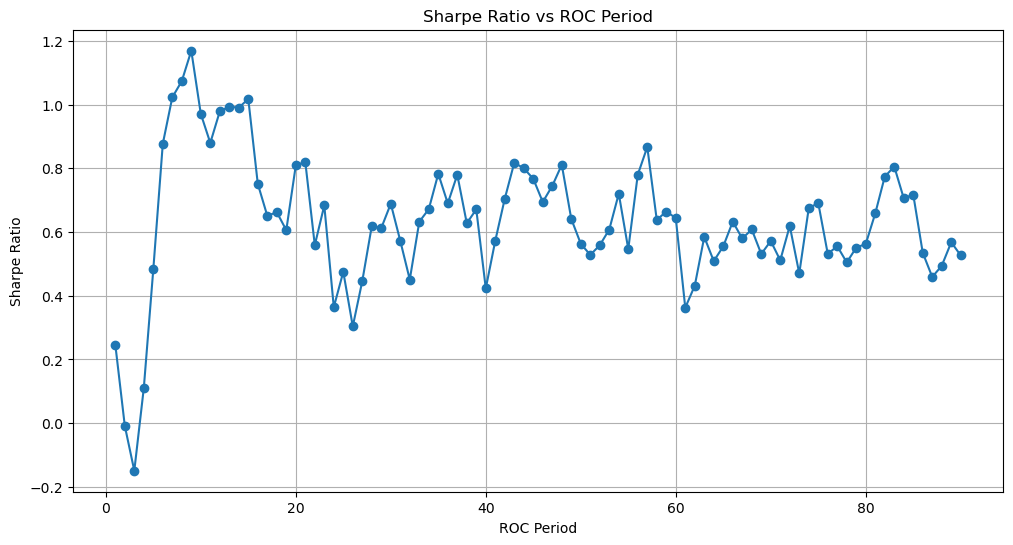

In [157]:
roc_periods = range(1, 91)
roc_periods, all_returns = run_strategy_with_pyfolio(roc_periods)

sharpe_ratios = []
for returns in all_returns:
    sharpe_ratio = returns.mean() / returns.std() * (252 ** 0.5)
    sharpe_ratios.append(sharpe_ratio)

plt.figure(figsize=(12, 6))
plt.plot(roc_periods, sharpe_ratios, marker='o')
plt.title("Sharpe Ratio vs ROC Period")
plt.xlabel("ROC Period")
plt.ylabel("Sharpe Ratio")
plt.grid()
plt.show()

In [164]:
# Найдем период при котором шарп максимален
# for i in zip(roc_periods, sharpe_ratios):
#     print(i[0], i[1])
print(roc_periods[sharpe_ratios.index(max(sharpe_ratios))])

9


Оценим стратегию с таким период детальнее

In [166]:
cerebro = bt.Cerebro()

data = bt.feeds.GenericCSVData(
    dataname='/Users/timurgattarov/algotrading/Onboarding Research/AAPL_2019_to_2025_daily.csv',
    dtformat='%Y-%m-%d',
    timeframe=bt.TimeFrame.Days,
    fromdate=datetime.datetime(2020, 1, 1),
    # Указываем индексы столбцов
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)
cerebro.adddata(data)

cerebro.addstrategy(ROCMomentumStrategy, roc_period=9)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.broker.set_cash(1000000.0)

results = cerebro.run()

Start date,2020-01-02
End date,2024-12-31
Total months,59
,Backtest
Annual return,0.343%
Cumulative returns,1.725%
Annual volatility,0.293%
Sharpe ratio,1.17
Calmar ratio,1.20
Stability,0.94
Max drawdown,-0.286%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.29,2022-08-17,2022-12-14,2023-03-31,163
1,0.26,2021-12-10,2022-06-30,2022-08-03,169
2,0.26,2024-01-23,2024-05-01,2024-06-05,97
3,0.22,2024-07-16,2024-11-15,2024-12-10,106
4,0.19,2020-09-01,2021-04-01,2021-07-02,219


Stress Events,mean,min,max
Covid,0.00%,-0.10%,0.14%


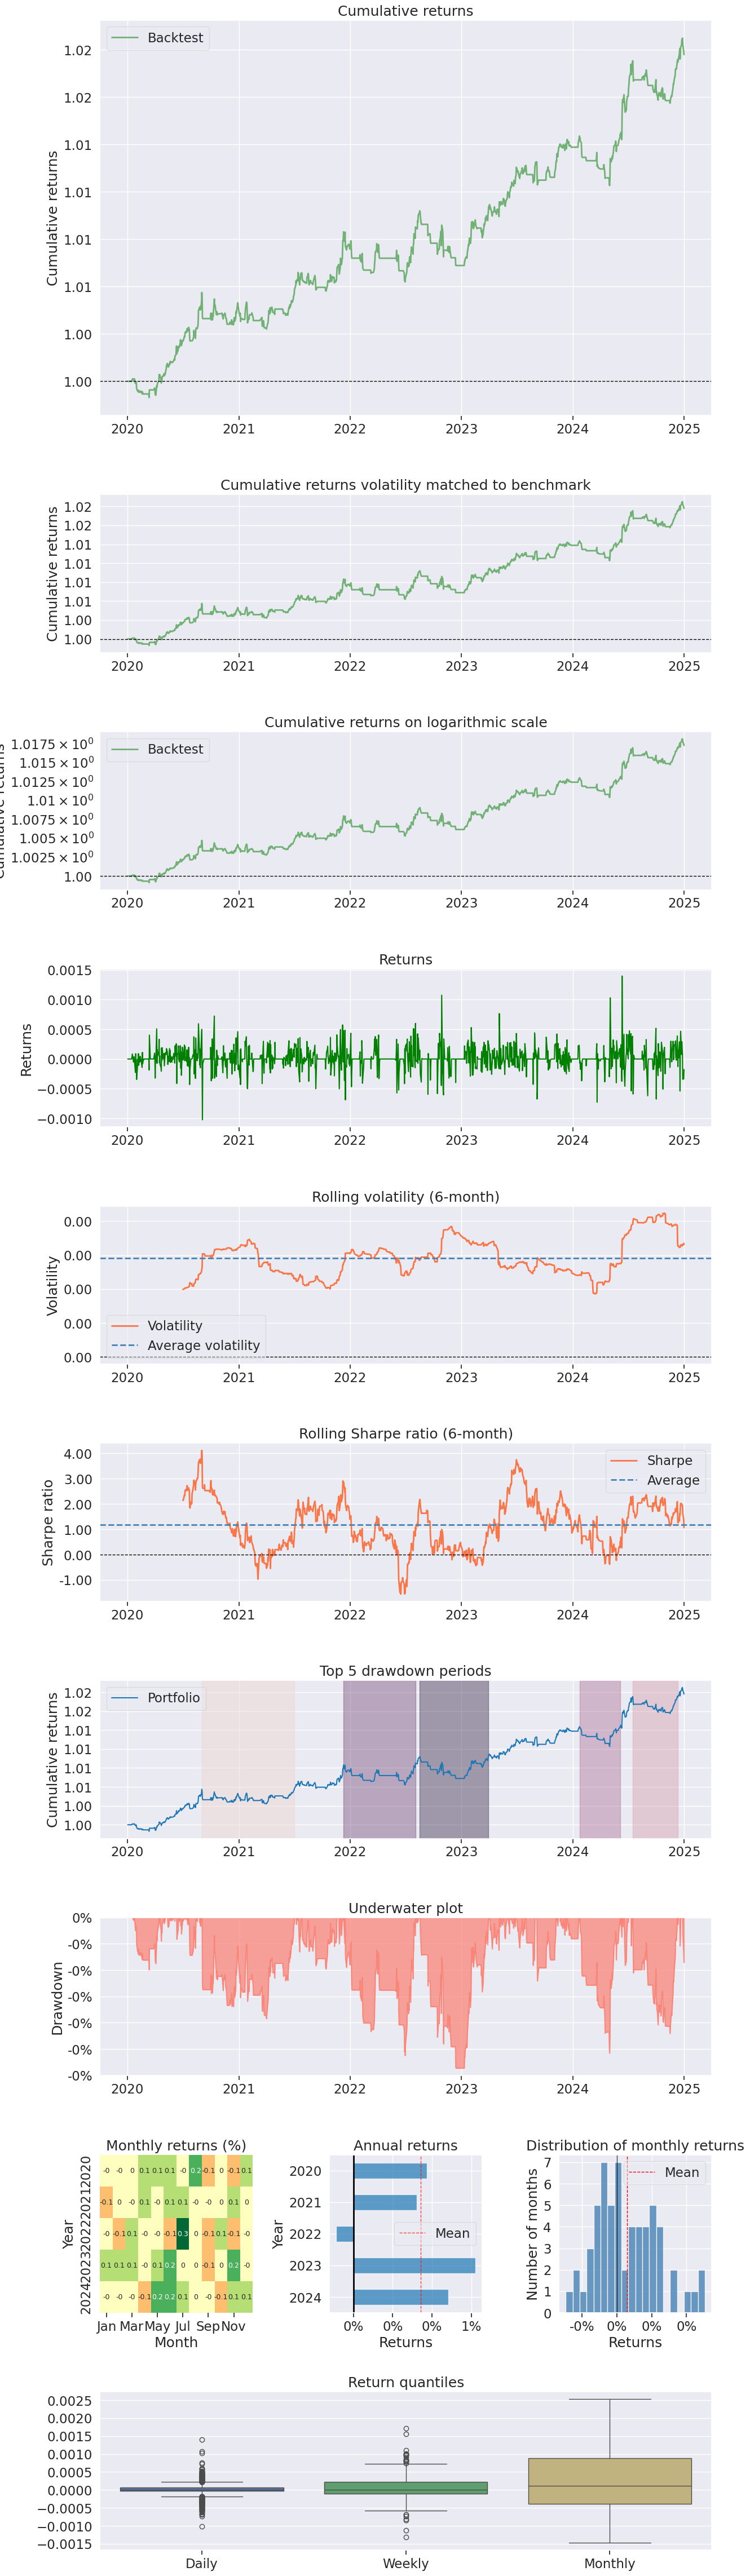

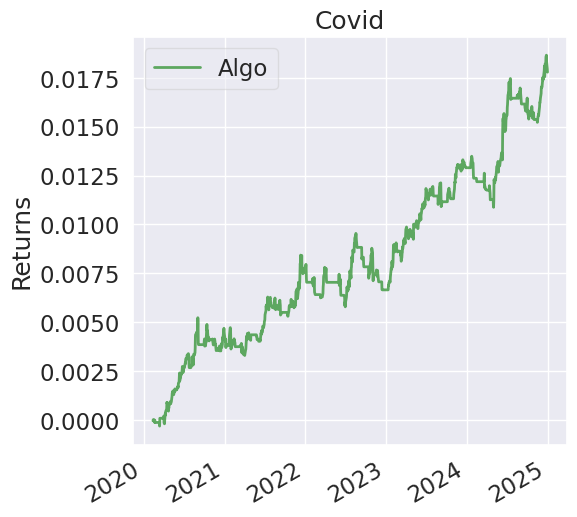

In [168]:
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
returns = pd.Series(returns, index=pd.to_datetime(returns.index))

pf.create_full_tear_sheet(
    returns=returns,
    benchmark_rets=None,
)
plt.show() 

## Summary

Таким образом, перебрав периоды определили `period=9` при котором коэффициент Шарпа максимален, получили значение `>1`, что уже внушает больше доверия. `Annual return & Cumulative returns` также получились лучше. Эксперимент с такой стратегией можно будет продолжить, исследуя зависимость параметров стратегии от продолжительности работы стратегии и других функций расчёта количества покупаемых лотов.

### Использованная литература и источники
1. Advanced Algorithmic Futures Trading with Limex
2. Hands-On Financial Trading with Python: A practical guide to using Zipline and other Python libraries for backtesting trading strategies
by Jiri Pik (Author), Sourav Ghosh (Author)
3. Backtrader Playlist by Part Time Larry https://youtu.be/UNkH1TQl7qo?si=3UtwE3w91lR4aw5g
4. Официальная документация Backtrader https://backtrader.ru/docu/introduction/
5. Sendex Youtube Channel Programming for Finance with Python and Quantopian and Zipline https://www.youtube.com/watch?v=RxjIOXstxCk